# SGDRegressor with multiple features (Mass + $T_\mathrm{eq}$ → Radius)

**Hands-on goal:** predict planet radius (`pl_rade`) from two features:
- planet mass (`pl_bmasse`)
- equilibrium temperature (`pl_eqt`)

We will use `sklearn.linear_model.SGDRegressor` to illustrate **Gradient Descent in practice** 

You will run the same SGD settings on:
- raw (unscaled) features
- scaled features (StandardScaler, MinMaxScaler, RobustScaler)

!keep `eta0` fixed and let us *see* how scaling changes convergence.


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score

np.random.seed(42)


## 1) Load data


In [13]:
DATA_PATHS = [
    Path("../data/nea_2026_jan.csv"),
    Path("nea_2026_jan.csv"),
]

data_path = next((p for p in DATA_PATHS if p.exists()), None)
if data_path is None:
    raise FileNotFoundError(
        "Could not find nea_2026_jan.csv. Tried:\n"
        + "\n".join([str(p) for p in DATA_PATHS])
        + "\n\nEdit DATA_PATHS to match your repository structure."
    )

df = pd.read_csv(data_path)
print(f"Loaded: {data_path}  |  shape={df.shape}")
df.head()


Loaded: ..\data\nea_2026_jan.csv  |  shape=(6065, 14)


,pl_name,hostname,default_flag,sy_snum,sy_pnum,discoverymethod,disc_year,pl_orbper,pl_orbsmax,pl_rade,pl_bmasse,pl_eqt,st_teff,st_met
0,11 Com b,11 Com,1,2,1,Radial Velocity,2007,323.21000,1.178,NaN,4914.898486,NaN,4874.0,-0.26
1,11 UMi b,11 UMi,1,1,1,Radial Velocity,2009,516.21997,1.530,NaN,4684.814200,NaN,4213.0,-0.02
2,14 And b,14 And,1,1,1,Radial Velocity,2008,186.76000,0.775,NaN,1131.151301,NaN,4888.0,-0.21
3,14 Her b,14 Her,1,1,2,Radial Velocity,2002,1765.03890,2.774,NaN,2559.472162,NaN,NaN,NaN
4,16 Cyg B b,16 Cyg B,1,3,1,Radial Velocity,1996,798.50000,1.660,NaN,565.737400,NaN,5750.0,0.06


## 2) Pick columns and clean


- `pl_rade` (target)
- `pl_eqt`  (feature)
- `pl_bmasse` (feature)



In [14]:
col_r = "pl_rade"
col_teq = "pl_eqt"
col_m = "pl_bmasse"


df2 = df[[col_m, col_teq, col_r]].replace([np.inf, -np.inf], np.nan).dropna()
df2 = df2[(df2[col_m] > 0) & (df2[col_teq] > 0) & (df2[col_r] > 0)]

print("Cleaned shape:", df2.shape)
df2.describe()


Cleaned shape: (1045, 3)


,pl_bmasse,pl_eqt,pl_rade
count,1045.000000,1045.000000,1045.000000
mean,379.026548,1137.848622,8.764727
std,860.528654,538.490200,5.938067
min,0.070000,124.700000,0.309800
25%,10.000000,696.300000,2.606000
50%,99.000000,1089.000000,10.054473
75%,340.395930,1505.000000,13.506822
max,8899.195396,4050.000000,33.600000


## 3) Train/test split

In [15]:
X = df2[[col_m, col_teq]].values
y = df2[col_r].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (783, 2) Test: (262, 2)


## 4) A minimal "SGD training loop" 

`SGDRegressor` trains iteratively. To **visualize convergence**, we:
- create an SGD model with `max_iter=1`
- call `.fit(...)` repeatedly with `warm_start=True` (When set to True, reuse the solution of the previous call to fit as initialization, otherwise, just erase the previous solution.)
- record MSE after each epoch

This is intentionally made simple and readable..


In [16]:
def run_sgd(X_train, y_train, X_test, y_test, *, scaler=None,
            eta0=0.01, epochs=80,  random_state=42):
    # 1) optionally scale
    if scaler is None:
        Xtr, Xte = X_train, X_test
        sc = None
    else:
        sc = scaler
        Xtr = sc.fit_transform(X_train)
        Xte = sc.transform(X_test)

    # 2) SGD model (one epoch at a time)
    model = SGDRegressor(
        loss="squared_error",
        learning_rate="constant",
        eta0=eta0,
        max_iter=1,
        tol=None,
        warm_start=True,
        random_state=random_state
    )

    mse_tr, mse_te = [], []
    for _ in range(epochs):
        model.fit(Xtr, y_train)
        mse_tr.append(mean_squared_error(y_train, model.predict(Xtr)))
        mse_te.append(mean_squared_error(y_test,  model.predict(Xte)))

    return model, sc, np.array(mse_tr), np.array(mse_te)


## 5) Run: raw vs scaled

Change these **three numbers** during the hands-on:
- `ETA0` (learning rate)
- `EPOCHS`


In [17]:
ETA0 = 0.01   # try different values
EPOCHS = 80   # try different values
ALPHA = 1e-4

experiments = [
    ("Raw (no scaling)", None),
    ("StandardScaler", StandardScaler()),
    ("MinMaxScaler", MinMaxScaler()),
    ("RobustScaler", RobustScaler()),
]

models = {}
curves = {}

for name, scaler in experiments:
    model, sc, mse_tr, mse_te = run_sgd(
        X_train, y_train, X_test, y_test,
        scaler=scaler, eta0=ETA0, epochs=EPOCHS,
    )
    models[name] = (model, sc)
    curves[name] = (mse_tr, mse_te)
    print(f"{name:>16s} | final MSE train={mse_tr[-1]:.4g} test={mse_te[-1]:.4g}")


Raw (no scaling) | final MSE train=3.487e+32 test=3.16e+32
  StandardScaler | final MSE train=22.4 test=17.4
    MinMaxScaler | final MSE train=21.88 test=17.4
    RobustScaler | final MSE train=25.41 test=19


## 6) Plot learning curves

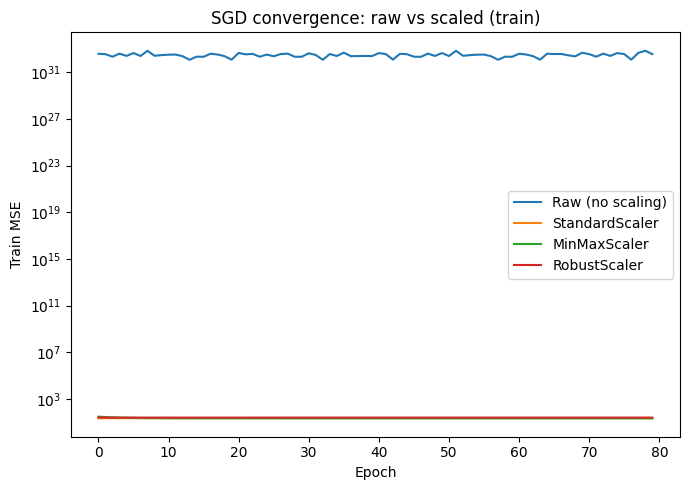

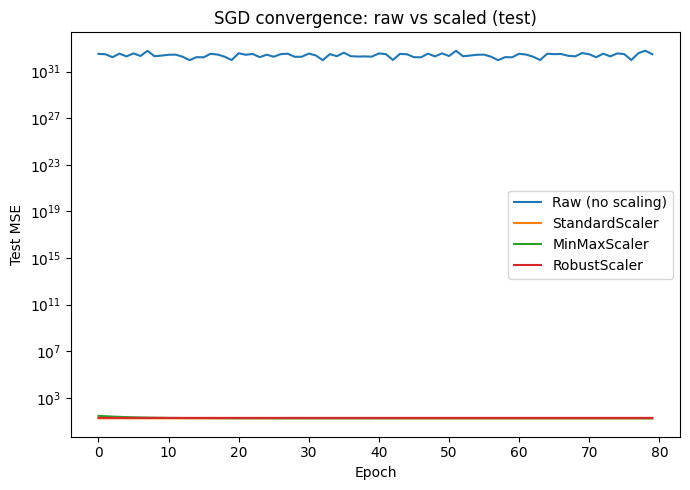

In [18]:
plt.figure(figsize=(7,5))
for name in curves:
    plt.plot(curves[name][0], label=name)
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Train MSE")
plt.title("SGD convergence: raw vs scaled (train)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,5))
for name in curves:
    plt.plot(curves[name][1], label=name)
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Test MSE")
plt.title("SGD convergence: raw vs scaled (test)")
plt.legend()
plt.tight_layout()
plt.show()


## 7) Final evaluation table

In [19]:
rows = []
for name, (model, sc) in models.items():
    Xte = X_test if sc is None else sc.transform(X_test)
    yhat = model.predict(Xte)
    rows.append([
        name,
        mean_squared_error(y_test, yhat),
        r2_score(y_test, yhat),
        model.coef_[0], model.coef_[1],
        model.intercept_[0],
    ])

out = pd.DataFrame(rows, columns=["Model", "Test MSE", "Test R2", "w_mass", "w_teq", "b"])
out.sort_values("Test MSE").reset_index(drop=True)


,Model,Test MSE,Test R2,w_mass,w_teq,b
0,StandardScaler,1.739785e+01,4.886025e-01,2.247021e+00,2.843027e+00,8.928495e+00
1,MinMaxScaler,1.740480e+01,4.883979e-01,1.526310e+01,2.161187e+01,2.584689e+00
2,RobustScaler,1.899655e+01,4.416096e-01,1.282818e+00,4.238649e+00,8.010203e+00
3,Raw (no scaling),3.160131e+32,-9.288983e+30,-1.232192e+13,-8.012386e+12,4.021533e+11


## 8) Plot: predicted vs true (raw vs best scaler)

We pick the best (lowest test MSE) and compare to the raw model.


Best: StandardScaler


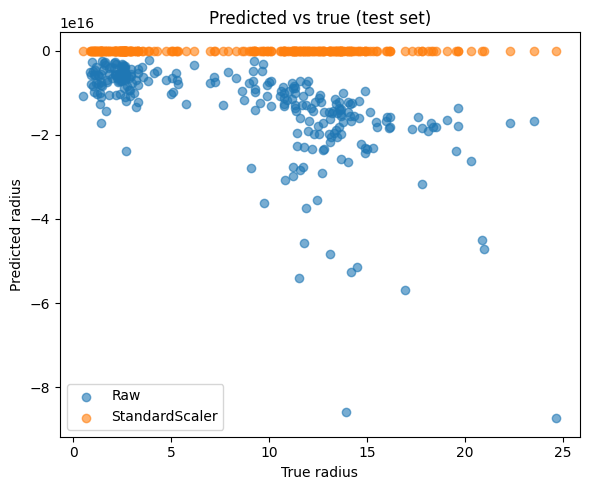

In [20]:
best_name = out.sort_values("Test MSE").iloc[0]["Model"]
print("Best:", best_name)

def predict(name, X):
    model, sc = models[name]
    X_ = X if sc is None else sc.transform(X)
    return model.predict(X_)

yhat_raw = predict("Raw (no scaling)", X_test)
yhat_best = predict(best_name, X_test)

plt.figure(figsize=(6,5))
plt.scatter(y_test, yhat_raw, alpha=0.6, label="Raw")
plt.scatter(y_test, yhat_best, alpha=0.6, label=best_name)
lims = [min(y_test.min(), yhat_raw.min(), yhat_best.min()),
        max(y_test.max(), yhat_raw.max(), yhat_best.max())]
#plt.plot(lims, lims)
plt.xlabel("True radius")
plt.ylabel("Predicted radius")
plt.title("Predicted vs true (test set)")
plt.legend()
plt.tight_layout()
plt.show()


## Challenge: Best **unscaled** vs best **scaled** model (only change `alpha` and `max_iter`)

In this notebook, the performance difference between *raw* and *scaled* features depends strongly on the learning rate.

Your task:

1. **Unscaled features**: use only the **Raw (no scaling)** features.
2. **Scaled features**: use **StandardScaler** (scaled features).
3. Search for the best combination of:
   - `alpha` = learning rate (this corresponds to `eta0` in `SGDRegressor`)
   - `max_iter` = number of epochs (this corresponds to `EPOCHS` in our `run_sgd` loop)

**Important rules**
- You may change **only** `eta0` and `max_iter`.
- Keep everything else the same: same train/test split, same loss, same learning_rate type, same random seed.

Report:
- the best (lowest) **test MSE** for **unscaled**
- the best (lowest) **test MSE** for **scaled**
- which one wins


In [21]:

alphas = [1e-8, 1e-3, ]      # try adding/removing values
max_iters = [20, 80, ]         # try adding/removing values

best_raw = None     # will store (best_mse, best_alpha, best_max_iter)
best_scaled = None  # will store (best_mse, best_alpha, best_max_iter)



print("best_raw   =", best_raw)
print("best_scaled=", best_scaled)

#winner = "RAW (no scaling)" if best_raw[0] < best_scaled[0] else "SCALED (StandardScaler)"
#print("Winner:", winner)


best_raw   = None
best_scaled= None



## Extra challenge (1 feature only): Mass → Radius

Now repeat the same "best model" comparison, but using **only one feature**:

- **Feature:** planet mass (`pl_bmasse`)
- **Target:** planet radius (`pl_rade`)


### Rules (same as before)

In [22]:

alphas = [1e-8, 1e-3, ]      # try adding/removing values
max_iters = [20, 80, ]         # try adding/removing values

best_raw = None     # will store (best_mse, best_alpha, best_max_iter)
best_scaled = None  # will store (best_mse, best_alpha, best_max_iter)



print("best_raw   =", best_raw)
print("best_scaled=", best_scaled)

#winner = "RAW (no scaling)" if best_raw[0] < best_scaled[0] else "SCALED (StandardScaler)"
#print("Winner:", winner)


best_raw   = None
best_scaled= None
